## VCB

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (80/20)
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.0560 - val_loss: 0.0012
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 6.6766e-04 - val_loss: 0.0012
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 5.9922e-04 - val_loss: 0.0015
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 5.6824e-04 - val_loss: 0.0015
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 5.4024e-04 - val_loss: 0.0015
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 5.1321e-04 - val_loss: 0.0014
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 4.8619e-04 - val_loss: 0.0013
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 4.6168e-04 - val_loss: 0.0013
Epoch 9/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 4.3856e-04 - val_loss: 0.0012
Epoch 10/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 4.1379e-04 - val_loss: 9.6023e-04
Epoch 11/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 3.9699e-04 - val_loss: 7.8577e-04
Epoc

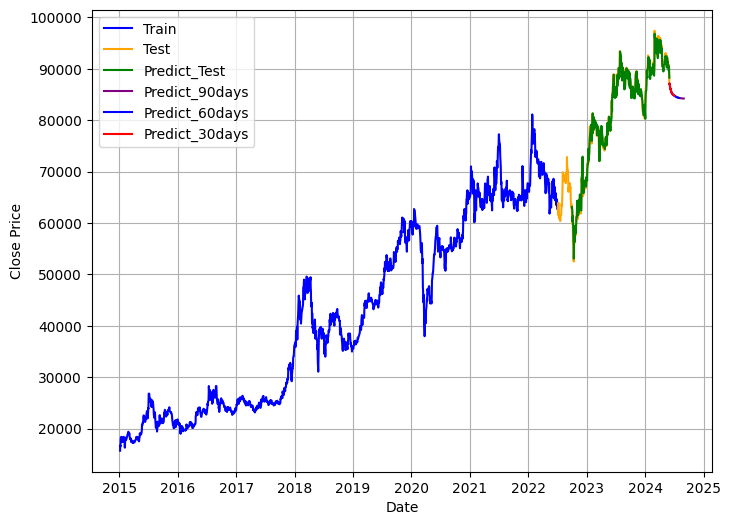

In [2]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')
plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')

# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('VCB Stock Price Forecast using LSTM 8:2')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)  
plt.show()

In [3]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)

Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  87058.781250
2024-06-02  87090.171875
2024-06-03  87002.507812
2024-06-04  86661.632812
2024-06-05  86258.250000
...                  ...
2024-08-25  84221.953125
2024-08-26  84219.976562
2024-08-27  84218.093750
2024-08-28  84216.312500
2024-08-29  84214.617188

[90 rows x 1 columns]


In [4]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1236.829635500719
MAPE: 1.1495641441463165 %
MAE: 907.5729645373772


## CTG

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../Dataset/CTG.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (80/20)
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.0372 - val_loss: 0.0019
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 9/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 9.6087e-04 - val_loss: 0.0019
Epoch 10/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 9.0868e-04 - val_loss: 0.0018
Epoch 11/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 8.6034e-04 - val_loss: 0.0017
Epoch 12/200
57/57 ━━━━━━━━━━━━━━━━━━━━

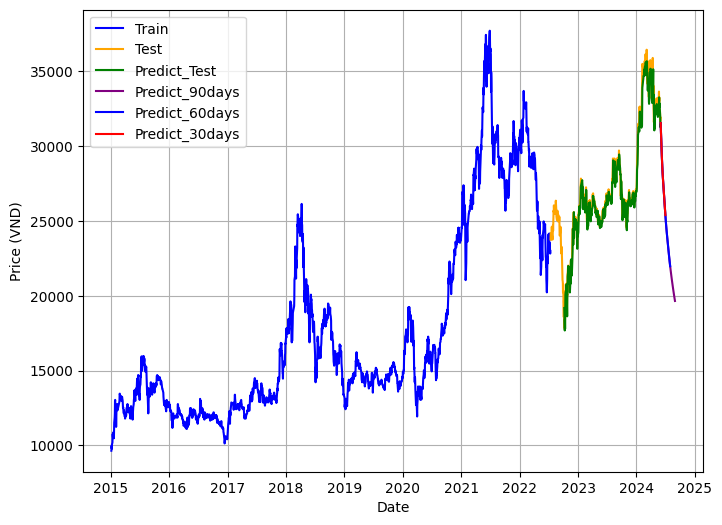

In [15]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('CTG Stock Price Forecast using LSTM 8:2')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [7]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)


Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  31440.894531
2024-06-02  30899.369141
2024-06-03  30439.525391
2024-06-04  30073.107422
2024-06-05  29665.337891
...                  ...
2024-08-25  14741.639648
2024-08-26  14672.070312
2024-08-27  14604.555664
2024-08-28  14539.053711
2024-08-29  14475.531250

[90 rows x 1 columns]


In [8]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 662.6849223530671
MAPE: 1.85714914006154 %
MAE: 510.2669430012225


## BID

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../Dataset/BID.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (80/20)
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  # Dự đoán 90 ngày
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - loss: 0.0298 - val_loss: 0.0013
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 8.7243e-04 - val_loss: 0.0014
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 7.8510e-04 - val_loss: 0.0017
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 7.3523e-04 - val_loss: 0.0016
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 6.7928e-04 - val_loss: 0.0016
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 6.2842e-04 - val_loss: 0.0016
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 5.9095e-04 - val_loss: 0.0014
Epoch 9/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 5.5891e-04 - val_loss: 0.0012
Epoch 10/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 5.3065e-04 - val_loss: 0.0011
Epoch 11/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 5.0562e-04 - val_loss: 9.9075e-04
Epoch 12/20

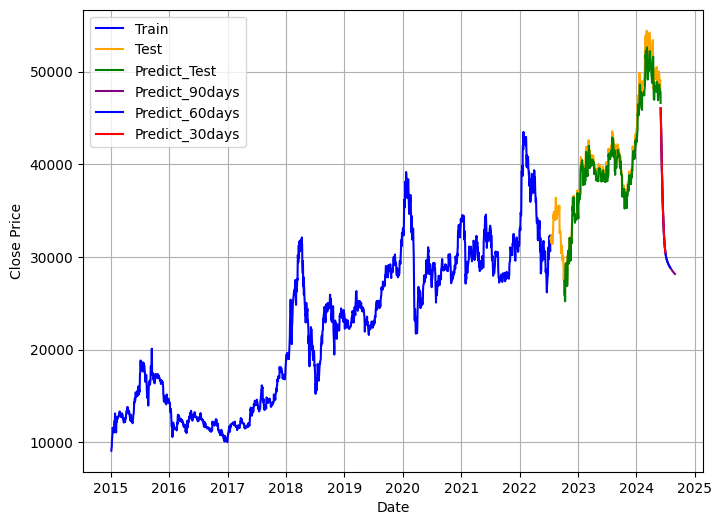

In [13]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')
plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')

# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('BID Stock Price Forecast using LSTM 8:2')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)  
plt.show()

In [11]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()})
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast BID stock prices for the next 90 days:")
print(future_df)


Forecast BID stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  46013.660156
2024-06-02  45013.257812
2024-06-03  44050.832031
2024-06-04  43113.171875
2024-06-05  42203.003906
...                  ...
2024-08-25  28241.767578
2024-08-26  28222.302734
2024-08-27  28203.111328
2024-08-28  28184.183594
2024-08-29  28165.517578

[90 rows x 1 columns]


In [12]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1098.9597148698651
MAPE: 2.006955358908316 %
MAE: 842.6640004202322
